In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import glob
import librosa
import numpy as np

from torchsummary import summary

In [2]:
class AudioDataset(Dataset):
    def __init__(self, path, transform=None, sample_rate=16000):
        self.path = path
        self.data_list = glob.glob(self.path + '/*.wav')
        
        self.transform = transform
        self.sr = sample_rate
        
        self.max = 1
        self.min = -1
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        data_path = self.data_list[idx]
        data = self.normalize(self.load_wav(data_path))
#         data = np.expand_dims(data, axis=0)
        
        if self.transform is not None:
            data = self.transform(data)
        
        return data # (16000)
    
    def load_wav(self, wav_file):
        y, sr = librosa.load(wav_file, sr=self.sr)        
        return y
    
    def normalize(self, s):
        s = (s - self.min) / (self.max - self.min)
        
        return s

In [3]:
dataset = AudioDataset(path='data/원천데이터/normal_1s')

dataset.__len__()
dataset_indices = list(range(dataset.__len__()))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.2 * dataset.__len__()))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(dataset=dataset, batch_size=100, sampler=train_sampler, shuffle=False)
val_loader = DataLoader(dataset=dataset, batch_size=100, sampler=val_sampler, shuffle=False)

In [4]:
data_max = 0
data_min = 100
for data in train_loader:
    if data.max() > data_max:
        data_max = data.max()
    if data.min() < data_min:
        data_min = data.min()
data_max, data_min

(tensor(0.9828), tensor(0.0239))

In [5]:
abnormal_dataset = AudioDataset(path='data/원천데이터/abnormal_1s')

abnormal_loader = DataLoader(dataset=abnormal_dataset, batch_size=1, shuffle=False)

data_max = 0
data_min = 100
for data in abnormal_loader:
    if data.max() > data_max:
        data_max = data.max()
    if data.min() < data_min:
        data_min = data.min()
data_max, data_min

(tensor(1.0000), tensor(0.))

In [6]:
class AE(nn.Module):
    def __init__(self, input_dim=16000):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()
        )
        
    
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out
    
    def get_codes(self, x):
        return self.encoder(x)

ae = AE()
if torch.cuda.is_available():
    ae.cuda()

In [7]:
ae

AE(
  (encoder): Sequential(
    (0): Linear(in_features=16000, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=16000, bias=True)
    (3): Sigmoid()
  )
)

In [8]:
summary(ae, (16000,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]      16,385,024
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 512]         524,800
              ReLU-4                  [-1, 512]               0
            Linear-5                 [-1, 1024]         525,312
              ReLU-6                 [-1, 1024]               0
            Linear-7                [-1, 16000]      16,400,000
           Sigmoid-8                [-1, 16000]               0
Total params: 33,835,136
Trainable params: 33,835,136
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.28
Params size (MB): 129.07
Estimated Total Size (MB): 129.42
----------------------------------------------------------------


In [9]:
def train(model, loss, optimizer, num_epochs, early_stopping=False):
    train_loss_arr = []
    test_loss_arr = []
    
    best_test_loss = 9999999999
    early_stop, early_stop_max = 0, 3
    
    for epoch in range(num_epochs):
        
        epoch_loss = 0.
        for batch_idx, data in enumerate(train_loader):
            data = data.cuda()
            optimizer.zero_grad()
            
            model.train()
            outputs = model(data)
            train_loss = loss(outputs, data)
            epoch_loss += train_loss.data
            
            train_loss.backward()
            optimizer.step()
            
            if batch_idx % 10 == 0:
                print(f'Epoch : {epoch+1} [{batch_idx * len(data)}/{len(train_idx)} ({100. * batch_idx / len(train_idx) :.2f}%)]\
                \tLoss : {train_loss.data / len(data) :.8f}')
        
        train_loss_arr.append((epoch_loss / len(train_idx)).cpu())
        
        # validation
        model.eval()
        
        test_loss = 0.

        for data in val_loader:
            data = data.cuda()

            outputs = model(data)
            batch_loss = loss(outputs, data)
            test_loss += batch_loss.data

        test_loss_arr.append((test_loss / len(val_idx)).cpu())

        if early_stopping:
            if best_test_loss > test_loss:
                best_test_loss = test_loss
                early_stop = 0
                print(f'Epoch [{epoch+1}/{num_epochs}], Average Train Loss : {train_loss_arr[epoch] :.8f}, ' +\
                f'Average Test Loss : {test_loss_arr[epoch] :.8f}\n')
            else:
                early_stop += 1
                print(f'Epoch [{epoch+1}/{num_epochs}], Average Train Loss : {train_loss_arr[epoch] :.8f}, '+\
                f'Average Test Loss : {test_loss_arr[epoch] :.8f}\n')

            if early_stop >= early_stop_max:
                break
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}], Average Train Loss : {train_loss_arr[epoch] :.8f}, ' +\
            f'Average Test Loss : {test_loss_arr[epoch] :.8f}\n')

    return train_loss_arr, test_loss_arr

In [10]:
ae_loss = nn.MSELoss()
# ae_loss = nn.BCELoss()

ae_optimizer = optim.Adam(ae.parameters())

avg_train_loss, avg_test_loss = train(ae, ae_loss, ae_optimizer, 20, early_stopping=True)

Epoch : 1 [0/2700 (0.00%)]                	Loss : 0.00000335
Epoch : 1 [1000/2700 (0.37%)]                	Loss : 0.00000270
Epoch : 1 [2000/2700 (0.74%)]                	Loss : 0.00000274
Epoch [1/20], Average Train Loss : 0.00000430, Average Test Loss : 0.00000275

Epoch : 2 [0/2700 (0.00%)]                	Loss : 0.00000357
Epoch : 2 [1000/2700 (0.37%)]                	Loss : 0.00000183
Epoch : 2 [2000/2700 (0.74%)]                	Loss : 0.00000256
Epoch [2/20], Average Train Loss : 0.00000271, Average Test Loss : 0.00000272

Epoch : 3 [0/2700 (0.00%)]                	Loss : 0.00000250
Epoch : 3 [1000/2700 (0.37%)]                	Loss : 0.00000367
Epoch : 3 [2000/2700 (0.74%)]                	Loss : 0.00000226
Epoch [3/20], Average Train Loss : 0.00000271, Average Test Loss : 0.00000275

Epoch : 4 [0/2700 (0.00%)]                	Loss : 0.00000322
Epoch : 4 [1000/2700 (0.37%)]                	Loss : 0.00000251
Epoch : 4 [2000/2700 (0.74%)]                	Loss : 0.00000263
Epoch [

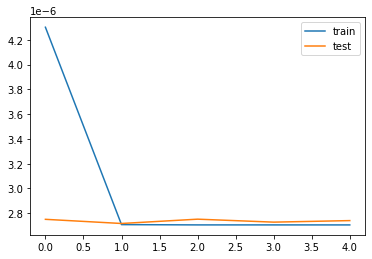

In [11]:
import matplotlib.pyplot as plt
plt.plot(avg_train_loss, label='train')
plt.plot(avg_test_loss, label='test')
plt.legend()

In [12]:
normal_dataset = AudioDataset(path='data/원천데이터/normal_1s')
abnormal_dataset = AudioDataset(path='data/원천데이터/abnormal_1s')

normal_loader = DataLoader(dataset=normal_dataset, batch_size=1, shuffle=False)
abnormal_loader = DataLoader(dataset=abnormal_dataset, batch_size=1, shuffle=False)

In [13]:
mse = nn.MSELoss()

normal_loss = []
ae.eval()
for idx, normal_data in enumerate(normal_loader):
    normal_data = normal_data.cuda()
    output = ae(normal_data)
    loss = mse(normal_data, output)
    normal_loss.append(loss.item())
    if (idx+1) % 100 == 0:
        print(f'--{((idx+1) / normal_loader.__len__()) * 100 :0.2f}%', end='')
print("--100% \n done")

--2.96%--5.93%--8.89%--11.85%--14.81%--17.78%--20.74%--23.70%--26.67%--29.63%--32.59%--35.56%--38.52%--41.48%--44.44%--47.41%--50.37%--53.33%--56.30%--59.26%--62.22%--65.19%--68.15%--71.11%--74.07%--77.04%--80.00%--82.96%--85.93%--88.89%--91.85%--94.81%--97.78%--100% 
 done


In [14]:
abnormal_loss = []
ae.eval()
for idx, abnormal_data in enumerate(abnormal_loader):
    abnormal_data = abnormal_data.cuda()
    output = ae(abnormal_data)
    loss = mse(abnormal_data, output)
    abnormal_loss.append(loss.item())
    if (idx+1) % 100 == 0:
        print(f'--{((idx+1) / abnormal_loader.__len__()) * 100 :0.2f}%', end='')
print("--100% \n done")

--3.46%--6.91%--10.37%--13.82%--17.28%--20.73%--24.19%--27.64%--31.10%--34.55%--38.01%--41.47%--44.92%--48.38%--51.83%--55.29%--58.74%--62.20%--65.65%--69.11%--72.56%--76.02%--79.47%--82.93%--86.39%--89.84%--93.30%--96.75%--100% 
 done


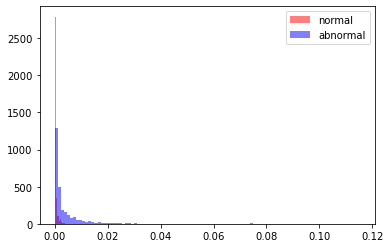

In [15]:
import matplotlib.pyplot as plt


plt.hist(normal_loss, color='r', alpha=0.5, bins=10, label='normal')
plt.hist(abnormal_loss, color='b', alpha=0.5, bins=100, label='abnormal')
plt.legend()

plt.show()

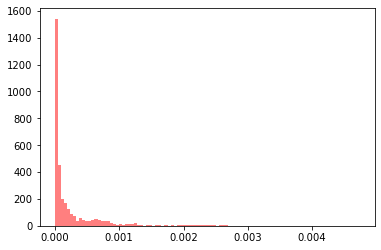

In [16]:
plt.hist(normal_loss, color='r', alpha=0.5, bins=100, label='normal')
plt.show()

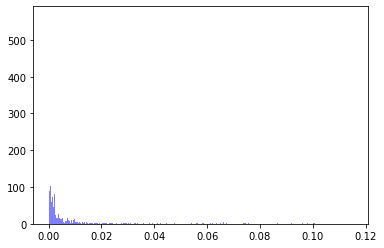

In [17]:
plt.hist(abnormal_loss, color='b', alpha=0.5, bins=1000, label='abnormal')
plt.show()

In [18]:
len(normal_loss), len(abnormal_loss)

(3375, 2894)

In [19]:
normal_loss = np.array(normal_loss)
len(normal_loss), sum(normal_loss > 0.001)

(3375, 236)

In [20]:
abnormal_loss = np.array(abnormal_loss)
len(abnormal_loss), sum(abnormal_loss > 0.001)

(2894, 1673)

In [34]:
def normalize(x):
    return (x + 1) / 2

def denormalize(x):
    return x*2 - 1

In [42]:
import soundfile as sf

data_path = 'data/원천데이터/normal_1s/실내_673584_label_0.wav'
# data_path = 'data/원천데이터/abnormal_1s/가스사고_511209_label_1.wav'
y, sr = librosa.load(data_path, sr=16000)

max(y), min(y)
# sf.write("test.wav", y, sr)

(0.0134887695, -0.01184082)

In [43]:
output = ae(torch.Tensor(normalize(y)).cuda()).cpu().detach().numpy()
max(output), min(output)

(0.5016489, 0.49852568)

In [44]:
out = denormalize(output)
max(out), min(out)

(0.0032978058, -0.0029486418)

In [45]:
sf.write("output.wav", out, sr)

In [62]:
data_path = 'data/원천데이터/normal_1s/실내_673584_label_3.wav'
y, sr = librosa.load(data_path, sr=16000)
a = torch.Tensor(normalize(y)).cuda()
b = ae(a)
c1 = mse(a, b).item()
c1

1.4990300769568421e-05

In [67]:
data_path = 'data/원천데이터/abnormal_1s/가스사고_511209_label_2.wav'
y, sr = librosa.load(data_path, sr=16000)
a = torch.Tensor(normalize(y)).cuda()
b = ae(a)
c2 = mse(a, b).item()
c2

0.00012860802235081792

In [68]:
c1 < c2

True